**Topic:** Kaggle Challenge [Quora Question Pairs](https://www.kaggle.com/c/quora-question-pairs/data)

Which of the provided pairs of questions contain two questions with the same meaning? The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. The labels, on the whole, represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.


**Scores:**

 - log_loss: official competition score
 - accuracy: relevant in real life

**General workflow:**

- load train data set
- cleanup (NaN's, non-English)
- tokenize
- perform semantic indexing/analysis
- compute similarity scores per pair
- train a classification algorithm for score -> is duplicate prediction
- compute scores for the test set

In [1]:
import sys
import os

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [4]:
# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
import sklearn.metrics.pairwise as smp
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF

In [5]:
# gensim
from gensim import corpora, models, similarities, matutils, \
    __version__ as gensim_version
gensim_version

2018-03-05 14:39:58,579 : INFO : 'pattern' package not found; tag filters are not available for English


'3.3.0'

In [6]:
# Load and cleanup the train set:
train_file = './data/quora/train.csv.zip'
df = pd.read_csv(train_file, header=0)
df.dropna(inplace=True)
df.shape

(404288, 6)

In [7]:
from sklearn.utils import shuffle

# Use a smaller sub-set to speed up the process; preserve the ratio
# of is_duplicate:
n_samples = 100000

ratio_1 = df['is_duplicate'].mean()
n_samples_1 = int(ratio_1 * n_samples)
use_df = pd.concat([
        shuffle(df[df['is_duplicate'] == 0], n_samples=(n_samples - n_samples_1)),
        shuffle(df[df['is_duplicate'] == 1], n_samples=n_samples_1)
    ],
    ignore_index=True
)

Extract the questions and the target flag:

In [8]:
q1 = use_df['question1'].values
q2 = use_df['question2'].values
is_dup = use_df['is_duplicate'].values

Minimal EDA, look for duplicate questions:

In [9]:
q1_unique, q1_unique_counts = \
    np.unique(q1, return_index=False, return_inverse=False, return_counts=True)

In [10]:
q1_num_dups, q1_dups_dist = \
    np.unique(q1_unique_counts, return_index=False, return_inverse=False, return_counts=True)

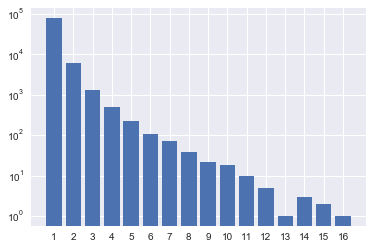

In [11]:
figure = plt.figure()
ax = plt.gca()
ax.bar(q1_num_dups, q1_dups_dist, log=True)
ax.set_xticks(np.arange(q1_num_dups.min(), q1_num_dups.max()+1))
plt.show()

Split 80/20 train/test:

In [13]:
q1_train, q1_test, \
    q2_train, q2_test, \
    is_dup_train, is_dup_test = \
        train_test_split(q1, q2, is_dup, test_size=.2, stratify=is_dup)

Vectorize the text; use both q1 and q2 (why? TBD):

In [14]:
tfidf = TfidfVectorizer(
    stop_words="english", 
    token_pattern=r'(?i)\b[a-z]{2,}\b', #words with >= 2 alpha chars 
    min_df=2
)

tfidf.fit(np.concatenate((q1_train, q2_train)))
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

q1_train_tfidf = tfidf.transform(q1_train)
q1_train_corpus = matutils.Sparse2Corpus(q1_train_tfidf.transpose())

q2_train_tfidf = tfidf.transform(q2_train)
q2_train_corpus = matutils.Sparse2Corpus(q2_train_tfidf.transpose())

q1_test_tfidf = tfidf.transform(q1_test)
q1_test_corpus = matutils.Sparse2Corpus(q1_test_tfidf.transpose())

q2_test_tfidf = tfidf.transform(q2_test)
q2_test_corpus = matutils.Sparse2Corpus(q2_test_tfidf.transpose())

Build LSI model on based on q1:

In [15]:
num_topics = 500
lsi = models.LsiModel(q1_train_corpus, id2word=id2word, num_topics=num_topics)

2018-03-05 14:40:55,042 : INFO : using serial LSI version on this node
2018-03-05 14:40:55,043 : INFO : updating model with new documents
2018-03-05 14:40:55,213 : INFO : preparing a new chunk of documents
2018-03-05 14:40:55,325 : INFO : using 100 extra samples and 2 power iterations
2018-03-05 14:40:55,326 : INFO : 1st phase: constructing (23653, 600) action matrix
2018-03-05 14:40:55,968 : INFO : orthonormalizing (23653, 600) action matrix
2018-03-05 14:40:59,721 : INFO : 2nd phase: running dense svd on (600, 20000) matrix
2018-03-05 14:41:01,043 : INFO : computing the final decomposition
2018-03-05 14:41:01,045 : INFO : keeping 500 factors (discarding 6.715% of energy spectrum)
2018-03-05 14:41:01,337 : INFO : processed documents up to #20000
2018-03-05 14:41:01,340 : INFO : topic #0(11.505): 0.853*"best" + 0.246*"way" + 0.156*"learn" + 0.119*"india" + 0.106*"make" + 0.103*"money" + 0.095*"does" + 0.085*"online" + 0.080*"quora" + 0.076*"life"
2018-03-05 14:41:01,342 : INFO : topic 

Transform q1, q2 into LSI space: 

In [16]:
q1_train_lsi = lsi[q1_train_corpus]
q2_train_lsi = lsi[q2_train_corpus]

q1_test_lsi = lsi[q1_test_corpus]
q2_test_lsi = lsi[q2_test_corpus]

Iterate through the 2 lists and compute the cosine similarity:

In [17]:
def cos_sim(lsi1, lsi2):
    v1 = [x[1] for x in lsi1]
    v2 = [x[1] for x in lsi2]
    try:
        return np.dot(v1, v2)/(np.linalg.norm(v1) * np.linalg.norm(v2))
    except ValueError:
        # This happens for docs that don't have a *single*
        # word in the TF-IDF vocabulary!
        return np.nan
    
def cos_sim_list(q1_lsi, q2_lsi):
    return np.array(list(map(lambda s: cos_sim(*s), zip(q1_lsi, q2_lsi))))

In [18]:
sim12_train = cos_sim_list(q1_train_lsi, q2_train_lsi)
sim12_test = cos_sim_list(q1_test_lsi, q2_test_lsi)

/Users/emy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Use SVM to map similarities into is_dup labels:

In [19]:
# Beware of NaN's:
train_index = ~np.isnan(sim12_train)
X_train = sim12_train[train_index].reshape(-1, 1)
y_train = is_dup_train[train_index]

In [20]:
np.count_nonzero(X_train < .5)

32106

In [127]:
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Compute the score:

In [ ]:
from sklearn.metrics import log_loss, accuracy_score

In [159]:
# Baseline score, assume random guessing with ratio_1 probability for 1:
baseline_accuracy_score = accuracy_score(
    is_dup, 
    np.random.binomial(1, ratio_1, size=len(is_dup))
)
baseline_log_loss_score = log_loss(
    is_dup,
    np.full_like(is_dup, ratio_1, dtype=np.float64)
)

In [155]:
# Beware of NaN's: predict where sim values exists, replace with the observed
# probability where they don't:
test_index = ~np.isnan(sim12_test)
n_fill = len(test_index) - np.count_nonzero(test_index)
X_test = sim12_test[test_index].reshape(-1, 1)

y_pred_test = np.zeros_like(is_dup_test)
y_pred_test[test_index] = svc.predict(X_test)
y_pred_test[~test_index] = np.random.binomial(1, ratio_1, size=n_fill)

y_pred_proba_test = np.full_like(is_dup_test, ratio_1, dtype=np.float64)
y_pred_proba_test[test_index] = svc.predict_proba(X_test)[:,1]

Accuracy test score = 0.6469
Log loss test score = 0.6190376783542203


In [164]:
print("Accuracy test score = {:.03f}, baseline = {:.03f}, higher is better".format(
    accuracy_score(is_dup_test, y_pred_test),
    baseline_accuracy_score
))
print("Log loss test score = {:.03f}, baseline = {:.03f}, lower is better".format(
    log_loss(is_dup_test, y_pred_proba_test),
    baseline_log_loss_score
))

Accuracy test score = 0.647, baseline = 0.533, higher is better
Log loss test score = 0.619, baseline = 0.659, lower is better
